# Trading Class => Mean Reversion Class

In [396]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
import numpy as np
import datetime as dt
import sqlite3
import time
import config 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline


class Trading:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["^GSPC","SPXL","XLK","XLU","XLI","XLY","XLP","XLB","XLM","XLV","XLE","BTC-USD", "AGG","JNK","LQD",
                   "CWB","BKLN","TIP","TLT","MUB","MBB","XLCPR","XLRE","^VIX", "SH","PSQ","RWM","USO","GDX","GDXJ","QQQ",'ETH-USD', 
                   'XRP-USD', "DX-Y.NYB",'ADA-USD', 'BNB-USD', 'DOGE-USD','FCX','NEM','XME','AA','NUE','RGLD'] 
        self.symbols_list = 'THREEFF2', 'THREEFF10','T10Y2Y','T5YIFR','T10YIE','VIXCLS','GVZCLS','VXNCLS','BAMLC0A4CBBBEY','BAMLC0A1CAAAEY','RVXCLS','VXEEMCLS'

    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        try:
            connection = sqlite3.connect('tradable_universe')
            for i in symbols:
                i.columns = 'close','ticker'
            final = pd.concat(symbols)
            final_df = final.reset_index()
            final_df.to_sql("macro_signals",connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
        except:
            print("There was an error in uploading the macro table into the sql database")
        return symbols, final_df

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("yahoo_investable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("yahoo_investable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from yahoo_investable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def load_sql_macro(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from macro_signals", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def triplet(self, tickers, final):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        return main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')   
    

class MeanReversion:
    
    """
    This script is for mean reversion trading strategies including Bollinger Bands Trading, Pairs / Triplets 
    Trading, and Long-Short Portfolio Trading. 
    """
    
    def __init__(self, dataframe):
        """ The inputs here are a time series dataframe that is ready with all the tickers. Start and end inputs 
        will filter the dataset further to account for specific regimes where certain tickers match the signal
        such as a smaller half-life or are cointegrated in that specific regime"""
        self.df = dataframe
    
    
    def adf_test(self, sig_level, start, end):
        """
        The null hypothesis is that the time series is not stationary... Need a test statistic that is less than the
        critical value. If this occurs, we can conclude the price series is stationary and not a random walk
        Inputs: sig_level comes in three forms ### "1%" , "5%" , "10%" ###
        """
        data = self.df[start:end]
        print(data)
        adf = ts.adfuller(data['Adj Close'])
        
        print('ADF Test Stats =', adf[0])
        print('ADF Critical Values', adf[4])

        if adf[0] < adf[4][sig_level]:
            print(f"This time series for {data['ticker'].iloc[-1]} is stationary at a {sig_level} significance level. ")
        else: 
            print(f"This time series for {data['ticker'].iloc[-1]} is not stationary at a {sig_level} significance level. ")
    
    
    
    def johansen_test(self, portfolio, start, end):
        """
        Inputs: Input three common securities - such as XLK XLM, and MTUM / QQQ in bull regimes - in a dataframe 
        with their adjusted close prices as values. The start and end dates depending on a specific time / regime.
        Outputs: Whether or not the three securities are cointegrated or not in that specific regime
        """
        print(portfolio)
        data = portfolio[start: end]
        print(data)
        result = coint_johansen(data, 0, 1)
        print('--------------------------------------------------')
        print('--> Trace Statistics')
        print('statistic : Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr1)):
            print("r <= " + str(i), round(result.lr1[i], 4), round(result.cvt[i, 0],4), round(result.cvt[i, 1],4), round(result.cvt[i, 2],4))
        print('--------------------------------------------------')
        print('--> Eigen Statistics')
        print('statistic : Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr2)):
            print("r <= " + str(i), round(result.lr2[i], 4), round(result.cvm[i, 0],4), round(result.cvm[i, 1],4), round(result.cvm[i, 2],4))
    
    
    
    def bollinger_bands(self, lookback, start, end):    
        """
        Inputs: The dataframe with a datetime index. Start and end are strings ("2012-01-01") [year-month-day].
        The lookback period has more to do with intuition based on the MA's and STDEV's
        Outputs: a dataset and the plot of the cumulative returns. 
        Most likely would like to check the security for stationarity first, such as FX or Volatility
        """
        print(self.df)
        df = self.df[start:end]
        lookback = 5
        df['moving_average'] = df['Adj Close'].rolling(lookback).mean()
        df['moving_std_dev'] = df['Adj Close'].rolling(lookback).std()
        df['upper_band'] = df.moving_average + 0.5*df.moving_std_dev
        df['lower_band'] = df.moving_average - 0.5*df.moving_std_dev
        df['long_entry'] = df['Adj Close'] < df.lower_band
        df['long_exit'] = df['Adj Close'] >= df.moving_average
        df['short_entry'] = df['Adj Close'] > df.upper_band
        df['short_exit'] = df['Adj Close'] <= df.moving_average
        df['positions_long'] = np.nan
        df.loc[df.long_entry, 'positions_long'] = 1
        df.loc[df.long_exit, 'positions_long'] = 0
        df['positions_short'] = np.nan
        df.loc[df.short_entry, 'positions_short'] = -1
        df.loc[df.short_exit, 'positions_short'] = 0
        df = df.fillna(method='ffill')
        df['positions'] = df.positions_long + df.positions_short
        df['prices_difference'] = df.Close - df.Close.shift(1)
        df['daily_returns'] = df.prices_difference / df.Close.shift(1)
        df['strategy_returns'] = df.positions.shift(1) * df.daily_returns
        df['cumret'] = (df.strategy_returns+1).cumprod()
        df.cumret.plot(label=f'{df.ticker.iloc[-1]}', figsize=(10, 5))
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.show()
        return df
    
    def mrs(self, df, lookback, std_dev, ticker, start, end, stop=True, stop_std=1.0):
        df = df[start:end]
        df['moving_average'] = df['Adj Close'].rolling(lookback).mean()     # moving average to be used for the bollinger bands
        df['moving_std_dev'] = df['Adj Close'].rolling(lookback).std()      # standard deviation to be used for the bollinger bands
        df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev    # upper band 
        df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev    # lower band
        df['long_entry'] = df['Adj Close'] < df.lower_band                  # enter when the close price dips below the lower band 
        df['long_exit'] = df['Adj Close'] >= df.moving_average              # exit the long when it reaches the moving average
        df['short_entry'] = df['Adj Close'] > df.upper_band       # enter a short position when the price exceeds the upper band
        df['short_exit'] = df['Adj Close'] <= df.moving_average   # exit the short when the price reaches the moving average
        df['positions_long'] = np.nan                 # initiate a long position column with NaN's for when no position will be taken
        df.loc[df.long_entry, 'positions_long'] = 1   # to note when we are long 
        df.loc[df.long_exit, 'positions_long'] = 0    # to note when we leave the position
        df['positions_short'] = np.nan                # initiate a short position column with NaN's for when no position will be taken
        df.loc[df.short_entry, 'positions_short'] = -1# to note when we are long
        df.loc[df.short_exit, 'positions_short'] = 0  # to note when we leave the position
        if stop:    # if statement for the stop loss
            df['long_sl'] = df['Adj Close'] < (df.lower_band - stop_std*df.moving_std_dev)  # stop loss for long positions
            df.loc[df.long_sl, 'positions_long_sl'] = 0     # zero when the stop loss occurs for long position
            df.loc[df.long_exit, 'positions_long_sl'] = 1   # stop loss for long exits
            df['short_sl'] = df['Adj Close'] > (df.upper_band + stop_std*df.moving_std_dev)
            df.loc[df.short_sl, 'positions_short_sl'] = 0
            df.loc[df.short_exit, 'positions_short_sl'] = 1
            df = df.fillna(method='ffill')                  # forward fill for NaN's
            df.positions_long = df.positions_long * df.positions_long_sl
            df.positions_short = df.positions_short * df.positions_short_sl
        df = df.fillna(method='ffill')
        df['positions'] = df.positions_long + df.positions_short
        df['prices_difference'] = df['Adj Close'] - df['Adj Close'].shift(1)
        df['daily_returns'] = df.prices_difference/df['Adj Close'].shift(1)
        df['strategy_returns'] = df.positions.shift(1) * df.daily_returns
        df['cumret'] = (df.strategy_returns+1).cumprod()
        print(f"The Cumulative Returns for {ticker}: {round(df.cumret.iloc[-1], 2)}%")          # printing the total return in the time period of the strategy
        df.cumret.plot(figsize=(8, 5))     # size of the plot
        plt.xlabel('Date')                 # X-axis title 
        plt.ylabel('Cumulative Returns')   # Y-axis title 
        plt.legend()                       # legend for the graph of the strategy
        plt.show()                         # plot the cumulative returns 
    
    


    ### took parts of this code from KidQuant - https://github.com/KidQuant/Pairs-Trading-With-Python/blob/master/PairsTrading.ipynb

    def find_cointegrated_pairs(self, df, start, end):
        """
        Inputs: The dataframe - created by triplet in the Trading Class - dataframe with the columns being the tickers
        and their subsequent adjusted close prices as their values. A start and end date as strings are used for regimes. 
        Outputs: Outputs a heatmap and a list of all the cointegrated tickers. 
        """
        
        df = df[start:end]      # this is used to fit a regime
        col = df.shape[1]
        score_matrix = np.zeros((col, col))
        pvalue_matrix = np.ones((col, col))
        keys = df.keys()
        pairs = []
        for i in range(col):
            for j in range(i+1, col):
                S1 = df[keys[i]]
                S2 = df[keys[j]]
                result = coint(S1, S2)
                score = result[0]
                pvalue = result[1]
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                if pvalue < 0.05:
                    pairs.append((keys[i], keys[j]))
        return score_matrix, pvalue_matrix, pairs 
    
    def pairs_trade(self, S1, S2, window1, window2, start, end):
        """
        Inputs: Security one and two (that are proved to be cointegrated) along with the trading windows. Start
        and end is included to account for favorable regimes. 
        Outputs: Outputs the total money earned doing this pairs trading strategy. 
        """
        S1 = S1[start:end]
        S2 = S2[start:end]
        
        if (window1 == 0) or (window2 == 0):
            return 0

        ratios = S1/S2
        ma1 = ratios.rolling(window=window1,
                                   center=False).mean()
        ma2 = ratios.rolling(window=window2,
                                   center=False).mean()
        std = ratios.rolling(window=window2,
                            center=False).std()
        zscore = (ma1 - ma2)/std

        money = 0
        countS1 = 0
        countS2 = 0
        for i in range(len(ratios)):
            # Sell short if the z-score is > 1
            if zscore[i] < -1:
                money += S1[i] - S2[i] * ratios[i]
                countS1 -= 1
                countS2 += ratios[i]
            # Buy long if the z-score is < -1
            elif zscore[i] > 1:
                money -= S1[i] - S2[i] * ratios[i]
                countS1 += 1
                countS2 -= ratios[i]
            # Clear positions if the z-score between -.5 and .5
            elif abs(zscore[i]) < 0.75:
                money += S1[i] * countS1 + S2[i] * countS2
                countS1 = 0
                countS2 = 0
        print(f"Strategy returned ${round(money, 2)} from {start} to {end}")

    
    def triplet(self, trip, lookback, start, end):
        """
        This is a trading strategy for a triplet cointegration. Use the johansen_test function to get 
        three common securities to see if they are cointegrated. If cointegrated use the same portfolio 
        to see the backtested results in the same regime. 
        Inputs: Start and end dates, same three security portfolio used in the johansen_test function
        """
        ticker1 = trip.columns[0]
        ticker2 = trip.columns[1]
        ticker3 = trip.columns[2]
        df = trip.dropna()
        df = df[start:end]
        
        result = coint_johansen(df[:90], 0, 1)  # results of Johansen test (first 90 days to avoid look-ahead bias)
        ev = result.evec                        # use this eigenvector to create the spread
        ev = result.evec.T[0]                   # transpose to get the cointegrating spread 
        ev = ev/ev[0]                           # Normalise the eigenvectors (divide row to get first value of eigenvector)
        print(f"Spread = {ev[0]}.{ticker1} + ({ev[1]}).{ticker2} + ({ev[2]}).{ticker3}")  # these will be the spreads of each of the three securities
        df = df[90:]                            # avoiding look ahead bias
        df['spread'] = df[f"{ticker1}"]*ev[0] + df[f"{ticker2}"]*ev[1] + df[f"{ticker3}"]*ev[2]   # looking at the spread  
        
        df['moving_average'] = df.spread.rolling(lookback).mean()      # for the upper / lower band of the cointegration strategy
        df['moving_std_dev'] = df.spread.rolling(lookback).std()       # for the upper / lower band of the cointegration strategy
        df['upper_band'] = df.moving_average + 0.5*df.moving_std_dev   # upper band 
        df['lower_band'] = df.moving_average - 0.5*df.moving_std_dev   # lower band

        df['long_entry'] = df.spread < df.lower_band       # enter long when the spread goes below the lower band
        df['long_exit'] = df.spread >= df.moving_average   # exit the long when the spread reaches the moving average
        df['short_entry'] = df.spread > df.upper_band      # enter short when the spread goes above the upper band
        df['short_exit'] = df.spread <= df.moving_average  # eexit the short when the spread reaches the moving average

        df['positions_long'] = np.nan                # place holder
        df.loc[df.long_entry, 'positions_long'] = 1  # equal to one when there is a long entered
        df.loc[df.long_exit, 'positions_long'] = 0   # equal to zero when the long is exited

        df['positions_short'] = np.nan                 # place holder
        df.loc[df.short_entry, 'positions_short'] = -1 # enter the short and set equal to negative one
        df.loc[df.short_exit, 'positions_short'] = 0   # exit the short and bring it back to zero for no position
        df = df.fillna(method='ffill')                 # forward fill to account for all the days where the position wasn't entered
        df['positions'] = df.positions_long + df.positions_short  # bring all the positions into one column

        df['spread_diff'] = df.spread-df.spread.shift(1)   # spread difference day over day (t over t-1)
        df['portfolio_value'] = abs(ev[0])*df[f"{ticker1}"] + abs(ev[1])*df[f"{ticker2}"] + abs(ev[2])*df[f"{ticker3}"]    # portfolio value calculation      
        df['daily_returns'] = df.spread_diff / df['portfolio_value'].shift(1)                # daily return calculation

        df['strategy_returns'] = df.daily_returns  * df.positions.shift(1)                   # strategy returns calculation
        df = df.dropna()                                        # remove any null values
        df['cumret'] = ((df.strategy_returns+1)).cumprod()      # cumulative returns for the strategy 

        df.cumret.plot(figsize=(10,5))  
        plt.xlabel('Date')  
        plt.ylabel('Cumulative Returns')  
        plt.legend()  
        plt.show()
        print(df)
    
    
    def long_short(self, tc, portfolio, slippage, start, end):
        """
        Inputs: the transactions cost (tc) which is normally 0.0001 - 0.0005 (slippage included). Portfolio which 
        should be a dataframe with the tickers adjusted close for the time series. Use the trip function to create
        this portfolio. Slippage is a boolean and False shows the strategy without approximating the slippage and
        transaction costs. 
        """
        print(portfolio)
        port = portfolio[start: end]
        print(port)
        port.iloc[:, :3].plot(figsize=(10, 5))                               # plotting the last three tickers in the portfolio
        plt.legend(loc='upper center', ncol=len(tickers))                    # there were five tickers 
        plt.show()


        daily_stock_returns = (port-port.shift(1))/port.shift(1)                  # calculating time series returns 
        daily_market_returns = np.sum(daily_stock_returns,axis=1)/len(tickers)    # equal weighted portfolio
        daily_market_returns.plot(figsize=(10,5))                                 # plot size
        plt.ylabel("Portfolio Returns")                                           # portfolio's returns 
        plt.show()

        weights  = daily_stock_returns.sub(daily_market_returns,axis=0)*-1.0     # ranking based on previous returns
        absolute_weights = weights.abs()                                         # buy holdings with previous bad returns (t-1)
        adjusted_weights = weights.div(np.sum(absolute_weights,axis=1),axis=0)   # sell holdings with previous good returns (t-1)

        daily_ret = adjusted_weights.shift(1) * daily_stock_returns  # new weights (long and short) of portfolio times the securities' returns
        daily_strategy_returns = np.sum(daily_ret,axis=1)            # summation of all the daily returns based on weighting


        if slippage == False:
            print(daily_strategy_returns.head()*100)                     # daily strategy returns
            (daily_strategy_returns+1).cumprod().plot(figsize=(10,5))    # cumulative returns of the strategy
            plt.xlabel("Date")                                           # X-axis title of the graph
            plt.ylabel("Cumulative Strategy Returns")                    # Y-axis title of the graph
            plt.show()
            ann_avg_ret=252*np.mean(daily_strategy_returns)*100          # annualized average return 
            print("Annualized strategy returns", round(ann_avg_ret,3),"%")        # printing those returns without slippage or transaction costs 
            sharpe = np.sqrt(252)*np.mean(daily_strategy_returns)/np.std(daily_strategy_returns)
            print("Sharpe Ratio",round(sharpe,3))                                 # printing the sharpe of the strategy without the slippage component

        else:
            daily_ret_minus_cost = np.sum(daily_ret - tc * np.abs(adjusted_weights - adjusted_weights.shift(1)),axis=1) # transaction costs (about)
            (daily_ret_minus_cost+1).cumprod().plot(figsize=(10,5))         # cumulative returns minus transaction costs (slippage too)
            plt.xlabel("Date")                                              # X-axis title 
            plt.ylabel("Cumulative Strategy Returns With Transaction Cost") # Y-axis title 
            plt.show()

            ann_avg_ret=252*np.mean(daily_ret_minus_cost)*100          # annualized ret. and slippage / transaction approx. accounted for 
            print("Annualized strategy returns", round(ann_avg_ret,3),"%")  
            sharpe = np.sqrt(252)*np.mean(daily_ret_minus_cost)/np.std(daily_ret_minus_cost)
            print("Sharpe Ratio",round(sharpe, 3))                     # annualized sr and slippage / transaction approx. accounted for 

# Instance - Trading Class

In [397]:
main = Trading(0, "2018-01-01", "2020-01-01")   # set first input to one if you want exact date inputs

# Yahoo Market Data

df, df1, df2 = main.yahoo_universe()            ### dont have to run this everytime

# Uploading to SQL Database

# Extracting the SQL Datatable

In [398]:
final = main.load_sql().set_index("Date")
print(final.ticker.unique())
final

['^GSPC' 'SPXL' 'XLK' 'XLU' 'XLI' 'XLY' 'XLP' 'XLB' 'XLM' 'XLV' 'XLE'
 'BTC-USD' 'AGG' 'JNK' 'LQD' 'CWB' 'BKLN' 'TIP' 'TLT' 'MUB' 'MBB' 'XLRE'
 '^VIX' 'SH' 'PSQ' 'RWM' 'USO' 'GDX' 'GDXJ' 'QQQ' 'ETH-USD' 'XRP-USD'
 'DX-Y.NYB' 'ADA-USD' 'BNB-USD' 'DOGE-USD' 'FCX' 'NEM' 'XME' 'AA' 'NUE'
 'RGLD']


,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
1988-01-25,246.529999,252.869995,246.500000,252.169998,252.169998,275250000.0,^GSPC
1988-01-26,252.130005,252.169998,249.100006,249.570007,249.570007,138380000.0,^GSPC
1988-01-27,249.580002,253.020004,248.500000,249.380005,249.380005,176360000.0,^GSPC
1988-01-28,249.389999,253.660004,249.380005,253.289993,253.289993,166430000.0,^GSPC
1988-01-29,253.309998,257.070007,252.699997,257.070007,257.070007,211880000.0,^GSPC
...,...,...,...,...,...,...,...
2023-01-09,125.790001,125.800003,122.209999,122.410004,122.410004,543100.0,RGLD
2023-01-10,122.400002,124.769997,121.760002,124.730003,124.730003,397500.0,RGLD
2023-01-11,124.889999,125.120003,122.510002,124.430000,124.430000,399400.0,RGLD


# ADF Test

In [399]:
ticker="^VIX"
df = main.ticker_filter(ticker, final)
mr = MeanReversion(df)
start = "2012-01-01"
end = "2015-01-01"
mr.adf_test("10%", start, end)

                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2012-01-03  22.950001  23.100000  22.540001  22.969999  22.969999     0.0   
2012-01-04  23.440001  23.730000  22.219999  22.219999  22.219999     0.0   
2012-01-05  22.750000  23.090000  21.340000  21.480000  21.480000     0.0   
2012-01-06  21.240000  21.719999  20.580000  20.629999  20.629999     0.0   
2012-01-09  21.670000  21.780001  21.000000  21.070000  21.070000     0.0   
...               ...        ...        ...        ...        ...     ...   
2014-12-24  14.520000  14.540000  14.010000  14.370000  14.370000     0.0   
2014-12-26  14.600000  14.840000  14.130000  14.500000  14.500000     0.0   
2014-12-29  16.040001  16.139999  15.060000  15.060000  15.060000     0.0   
2014-12-30  15.900000  16.200001  15.480000  15.920000  15.920000     0.0   
2014-12-31  15.910000  19.910000  15.860000  19.200001  19.200001     0.0   

# Bollinger Bands - No Stop Loss

The Cumulative Returns for ^VIX: 12.16%


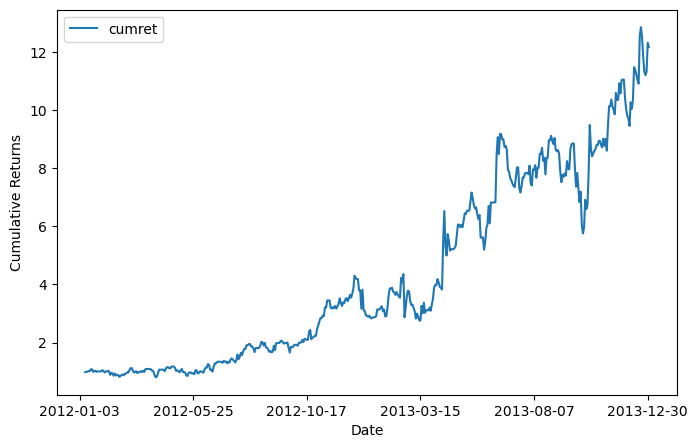

In [400]:
mr.mrs(df, lookback, 0.5, ticker, "2012-01-01","2014-01-01", stop=False)                   # no stop loss 

# Bollinger Bands - Stop Loss

The Cumulative Returns for ^VIX: 6.34%


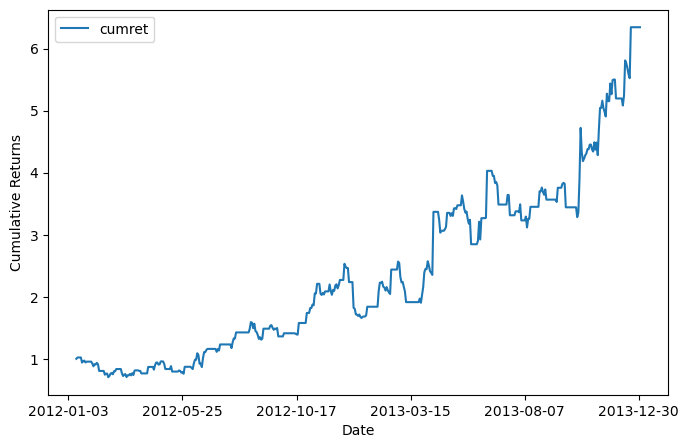

In [401]:
mr.mrs(df, lookback, 0.5, ticker, "2012-01-01","2014-01-01",stop=True, stop_std=stop_std)  # with a stop loss

# Finding Cointegrated Pairs - Metals and Mining

[('RGLD', 'XLB')]


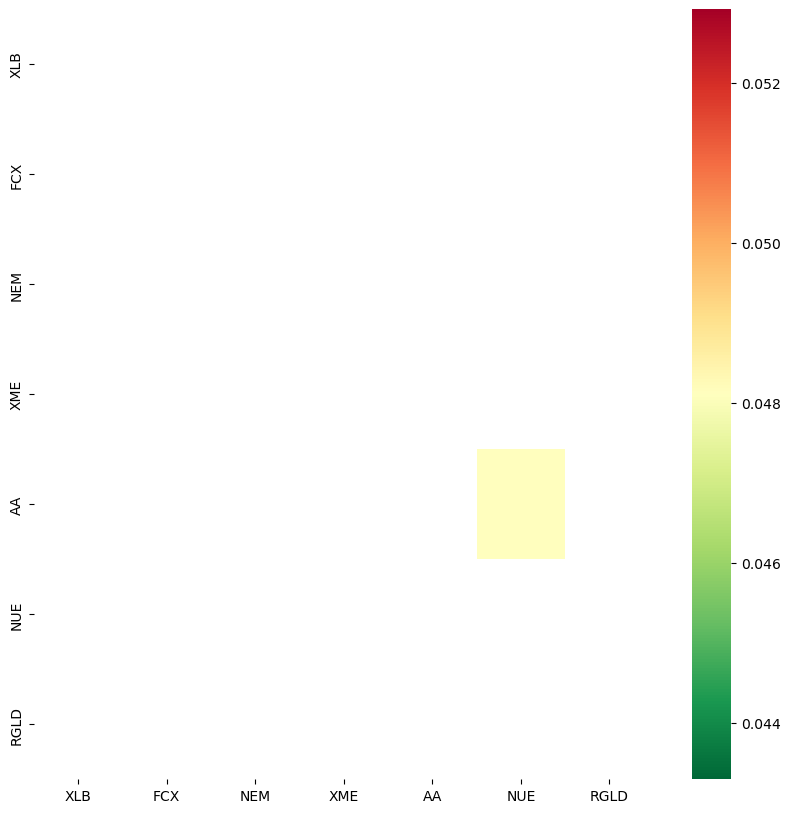

In [402]:
tickers = ["XLB", 'FCX', 'NEM', 'XME', 'AA', 'NUE', 'RGLD']
start = '2006-06-22'
end = '2023-01-01'
df = main.triplet(tickers, final).dropna()
scores, pvalues, pairs = mr.find_cointegrated_pairs(df, start, end)
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

# Checking the Pair for a Significant P-Value

In [403]:
S1 = df[pairs[0][0]]
S2 = df[pairs[0][1]]
print(f"{pairs[0][0]} and {pairs[0][1]}")
score, pvalue, _ = coint(S1, S2)
pvalue
### less than 0.05 means we can reject the null so they are in fact cointegrated

RGLD and XLB


0.044914091239218516

# Graphing the Spread Ratio

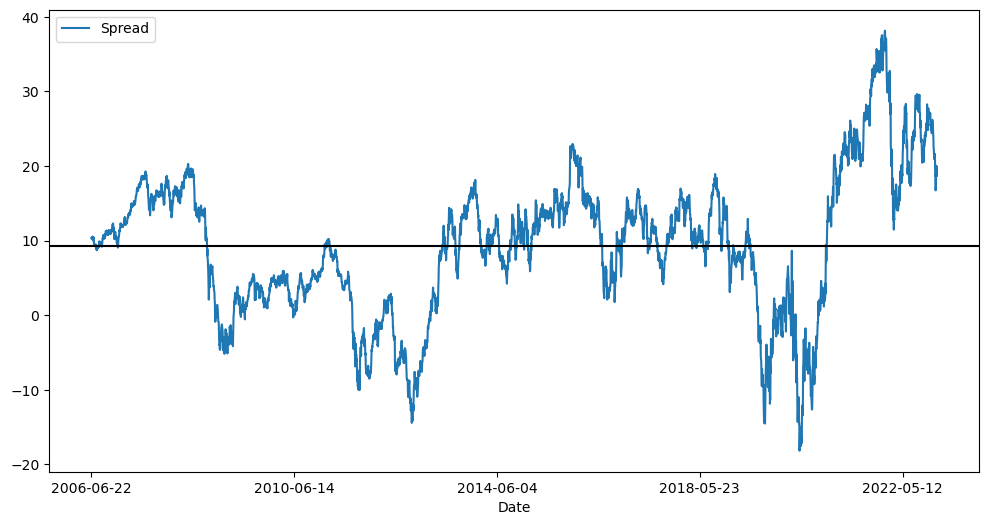

In [404]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[S1.columns[1]]
b = results.params[1]
spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

# Graphing the Price Ratio

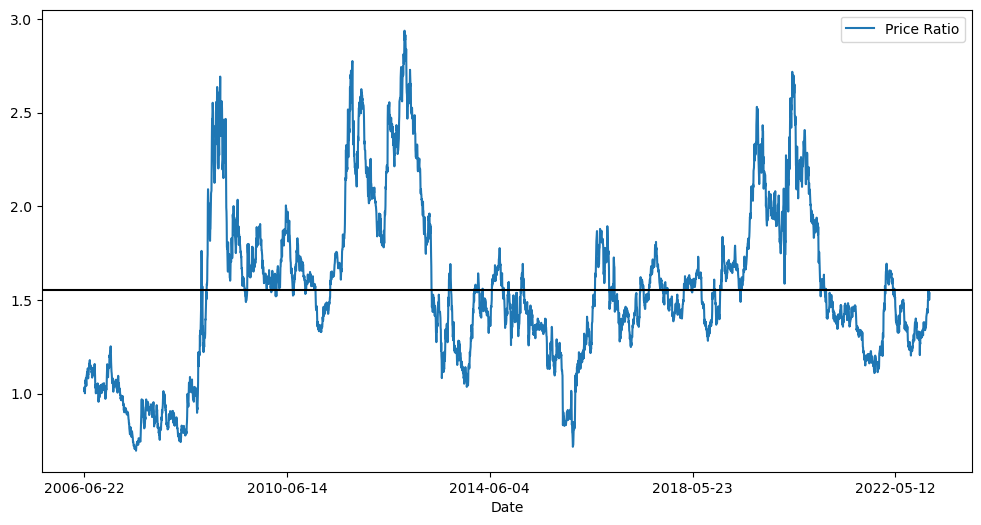

In [405]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

# Pair Trade Strategy Money Earned Through Backtest

In [406]:
mr.pairs_trade(S1, S2, 60, 5, start, end)

Strategy returned $771.39 from 2006-06-22 to 2023-01-01


# For the Triplets Cointegration Problem

Trace and Eigenvalues statistic are higher than the critical values up to 95% so we can deem these cointegrated. 
Ideally would want to create regimes first say based on Inflation and Nominal GDP differentials. 

In [414]:
#['FCX', 'NEM', 'XME', 'AA', 'NUE', 'RGLD']

trip = main.triplet(['RGLD', 'XLB', 'XME'], final).dropna()
mr = MeanReversion(trip)
start = "2014-01-01"
end = "2016-01-01"
mr.johansen_test(trip,start,end)

ticker            RGLD        XLB        XME
Date                                        
2006-06-22   21.560085  21.242170  35.976757
2006-06-23   22.125486  21.422190  36.711121
2006-06-26   22.133806  21.484501  36.966560
2006-06-27   21.618286  21.214474  36.695168
2006-06-28   21.302332  21.269867  36.990513
...                ...        ...        ...
2023-01-09  122.410004  80.879997  52.790001
2023-01-10  124.730003  81.690002  54.099998
2023-01-11  124.430000  82.970001  54.389999
2023-01-12  126.779999  83.279999  55.480000
2023-01-13  128.649994  83.790001  56.220001

[4170 rows x 3 columns]
ticker           RGLD        XLB        XME
Date                                       
2014-01-02  43.747200  38.213573  36.799862
2014-01-03  43.756107  38.121906  36.454723
2014-01-06  43.765034  37.913548  36.178616
2014-01-07  43.773956  37.846870  35.911144
2014-01-08  43.211933  38.071899  35.652294
...               ...        ...        ...
2015-12-24  34.753029  38.298695  14.1

Spread = 1.0.RGLD + (-88.36375383310578).XLB + (201.09709560192985).XME


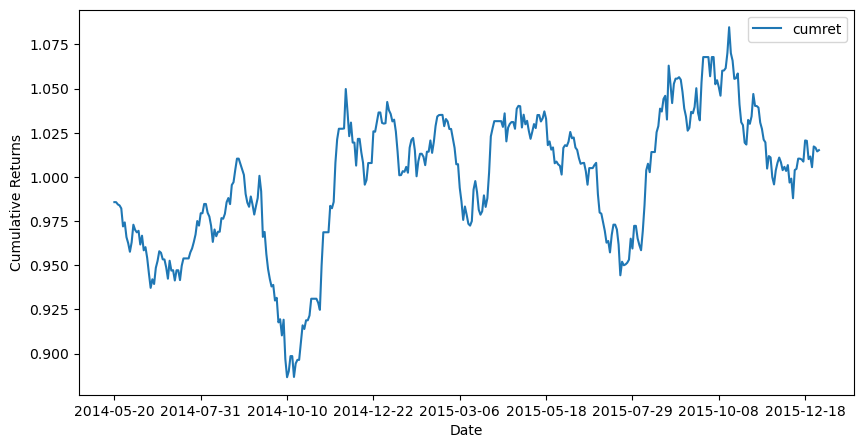

ticker           RGLD        XLB        XME       spread  moving_average  \
Date                                                                       
2014-05-20  57.309959  40.031395  34.524796  3462.821827     3598.365273   
2014-05-21  57.838039  40.215488  34.602623  3462.733543     3557.726366   
2014-05-22  57.453156  40.307526  34.576668  3448.996361     3519.219530   
2014-05-23  57.265205  40.650616  34.697723  3442.835499     3486.620521   
2014-05-27  54.723263  40.650616  34.619904  3424.644382     3448.406322   
...               ...        ...        ...          ...             ...   
2015-12-24  34.753029  38.298695  14.104288  -513.132076     -561.940464   
2015-12-28  33.701572  38.029545  13.628460  -586.088057     -558.567256   
2015-12-29  33.966717  38.385525  13.763128  -590.197298     -556.261402   
2015-12-30  32.851257  38.029545  13.547659  -603.187219     -568.598123   
2015-12-31  33.344986  37.699593  13.421970  -598.813385     -578.283607   

ticker     

In [415]:
mr.triplet(trip, lookback, start, end)

# Long Short Trading Strategy 

ticker           BTC-USD  DOGE-USD      ETH-USD       SPXL   XRP-USD
Date                                                                
2017-11-09   7143.580078  0.001415   320.884003  38.759998  0.217488
2017-11-10   6618.140137  0.001163   299.252991  38.684990  0.206483
2017-11-13   6559.490234  0.001211   316.716003  38.788120  0.203442
2017-11-14   6635.750000  0.001184   337.631012  38.534969  0.209825
2017-11-15   7315.540039  0.001339   333.356995  37.934921  0.212956
...                  ...       ...          ...        ...       ...
2023-01-09  17196.554688  0.075784  1321.538940  64.559998  0.349340
2023-01-10  17446.292969  0.077729  1336.586060  65.879997  0.351241
2023-01-11  17934.896484  0.078153  1387.932739  68.379997  0.374158
2023-01-12  18869.587891  0.080286  1417.938477  69.059998  0.375197
2023-01-13  19909.574219  0.084438  1451.614868  69.779999  0.385804

[1303 rows x 5 columns]
ticker           BTC-USD  DOGE-USD      ETH-USD        SPXL   XRP-USD
Date    

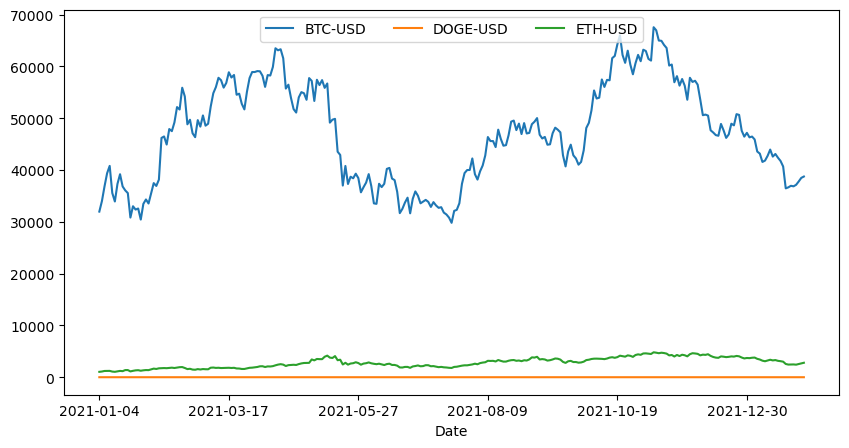

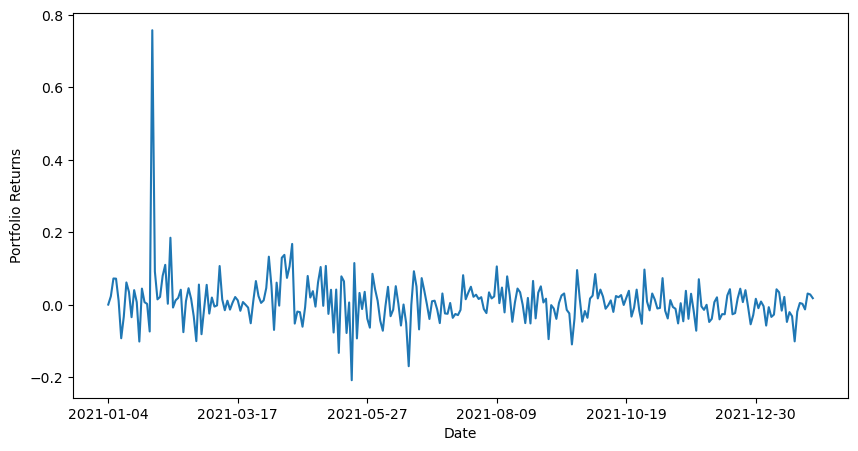

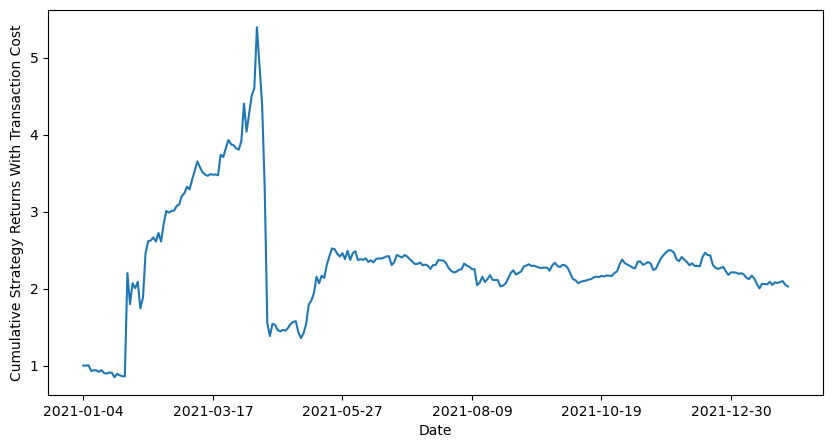

Annualized strategy returns 169.062 %
Sharpe Ratio 0.973


In [416]:
tc = 0.0001                                             # I believe the average is around 0.0005
slippage = True                                         # accounting for slippage and tc's
#tickers = ['^GSPC', 'SPXL', 'XLK', 'XLY', 'XLB','QQQ']  # random portfolio that would work well in bull regimes
tickers = ['BTC-USD','ETH-USD','SPXL','DOGE-USD','XRP-USD']
port = main.triplet(tickers, final).dropna()            # calling my function in the Trading Class
mr = MeanReversion(trip)                                # calling the MeanReversion Class  
start = "2021-01-01"                                    # start for the long_short trading strategy function
end = "2022-02-01"                                      # end for the long_short trading strategy function
mr.long_short(tc, port, slippage, start, end)      # calling the long_short strategy for the inputs above

# Getting Exact Ticker

In [417]:
ticker="^VIX"
df = main.ticker_filter(ticker, final)

# Getting Macro Signals and Creating Table

In [418]:
macro1, macro2 = main.macro()
macro2

,DATE,close,ticker
0,1990-01-02,7.8077,THREEFF2
1,1990-01-03,7.8637,THREEFF2
2,1990-01-04,7.8578,THREEFF2
3,1990-01-05,7.8623,THREEFF2
4,1990-01-08,7.8782,THREEFF2
...,...,...,...
76773,2023-01-06,22.7000,VXEEMCLS
76774,2023-01-09,23.2800,VXEEMCLS
76775,2023-01-10,21.7800,VXEEMCLS
76776,2023-01-11,22.6800,VXEEMCLS


# Loading Macro Datatable

In [419]:
main.load_sql_macro()

,DATE,close,ticker
0,1990-01-02 00:00:00,7.8077,THREEFF2
1,1990-01-03 00:00:00,7.8637,THREEFF2
2,1990-01-04 00:00:00,7.8578,THREEFF2
3,1990-01-05 00:00:00,7.8623,THREEFF2
4,1990-01-08 00:00:00,7.8782,THREEFF2
...,...,...,...
76773,2023-01-06 00:00:00,22.7000,VXEEMCLS
76774,2023-01-09 00:00:00,23.2800,VXEEMCLS
76775,2023-01-10 00:00:00,21.7800,VXEEMCLS
76776,2023-01-11 00:00:00,22.6800,VXEEMCLS


# Getting Exact Macro Signal

In [420]:
main.ticker_filter("THREEFF2", macro2)

,DATE,close,ticker
0,1990-01-02,7.8077,THREEFF2
1,1990-01-03,7.8637,THREEFF2
2,1990-01-04,7.8578,THREEFF2
3,1990-01-05,7.8623,THREEFF2
4,1990-01-08,7.8782,THREEFF2
...,...,...,...
8609,2023-01-02,NaN,THREEFF2
8610,2023-01-03,4.0812,THREEFF2
8611,2023-01-04,3.9938,THREEFF2
8612,2023-01-05,4.0153,THREEFF2
